In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import re
import sklearn
import nltk
import keras
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
# Helper libraries
import matplotlib.pyplot as plt
import os
import subprocess
import collections
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # Import to_categorical from the updated location

np.random.seed(1337)  # for reproducibility
from keras.layers import Dense, Dropout, Activation, Input,TimeDistributed,Flatten # Removed 'merge' and 'Lambda'
from keras.models import Sequential
from keras.layers import Embedding, LSTM # Use the standard LSTM layer instead of CuDNNLSTM
from keras.layers import Convolution1D, LSTM, Bidirectional
from keras.optimizers import Adadelta
from keras.preprocessing import sequence as sq
from keras.models import Model
from keras.callbacks import ModelCheckpoint

# Removed the import of keras.backend.tensorflow_backend as it's no longer needed

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DBM/train1.csv', encoding='utf-8')
print(df.shape)
print(df.head(4))

test = pd.read_csv('/content/drive/MyDrive/DBM/test1.csv', encoding='utf-8')
print(test.shape)
print(test.head(5))

(22070, 2)
                                             content  ground
0  Trong hình in chữ trắng nhận  hàng thì lại là ...       0
1  Chất liệu: Mềm nên mua nha.Màu sắc: Đúng với h...       1
2  Màu sắc: đúng với mô tảChất liệu: vải dùmặc và...       0
3                          Hàng hok như hình cho lắm       0
(2453, 2)
                                             content  ground
0  Giao hàng nhanh chóng, đóng gói cẩn thận, hàng...       1
1  Được biết shop qua group Cháy túi vì Shopee, t...       1
2                                     Chán thất vọng       0
3  Màu sắc: NâuQuần đẹp, rộng rãi, mình mua tặng ...       1
4  Shop soạn hàng rất ẩu. \nMình đặt lần đầu bị s...       0


In [ ]:
df.info

<bound method DataFrame.info of                                                  content  ground
0      Trong hình in chữ trắng nhận  hàng thì lại là ...       0
1      Chất liệu: Mềm nên mua nha.Màu sắc: Đúng với h...       1
2      Màu sắc: đúng với mô tảChất liệu: vải dùmặc và...       0
3                              Hàng hok như hình cho lắm       0
4      Xịn lắm nha mọi người ơi với cái giá này thì k...       1
...                                                  ...     ...
22065                                   Màu ko giống lắm       1
22066                               Đóng gói còn tốt nữa       1
22067          Thời gian giao hàng chậm, Không đáng tiền       0
22068  Chất liệu: kakiĐúng với mô tả: đúng như mô tảM...       1
22069                                      Hàng quá chất       0

[22070 rows x 2 columns]>

In [ ]:
import pandas as pd
import re
from pyvi import ViTokenizer

# Hàm để loại bỏ URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Hàm để loại bỏ emoji
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Hàm để đọc file chứa các từ viết tắt và từ thay thế vào dictionary
def load_abbreviations(file_path):
    abbreviations = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            short, full = line.strip().split(',')
            abbreviations[short] = full
    return abbreviations

# Hàm để thay thế các từ viết tắt trong văn bản
def replace_abbreviations(text, abbreviations):
    words = text.split()
    replaced_words = [abbreviations.get(word, word) for word in words]
    return ' '.join(replaced_words)

# Hàm để chuẩn hóa văn bản
def text_normalize(df, abbreviations_file, tokenize=False):
    abbreviations = load_abbreviations(abbreviations_file)

    # Convert text to lowercase
    df['content'] = df['content'].astype(str).str.lower()
    # Remove numbers and words with numbers
    df['content'] = df['content'].str.replace('\w*\d\w*', ' ', regex=True)
    # Remove URLs
    df['content'] = df['content'].apply(remove_urls)
    # Remove punctuation
    df['content'] = df['content'].str.replace('[^\w\s]', ' ', regex=True)
    # Remove emojis
    df['content'] = df['content'].apply(remove_emojis)
    # Replace abbreviations
    df['content'] = df['content'].apply(lambda x: replace_abbreviations(x, abbreviations))
    # Remove whitespaces
    df['content'] = df['content'].str.split().apply(lambda x: ' '.join(word for word in x))
    # Tokenize
    if tokenize:
        df['content'] = df['content'].apply(lambda x: ViTokenizer.tokenize(x))
    return df

abbreviations_file = 'abbreviate.txt'


In [ ]:
# In 'ipython-input-8-c89579f4e03c'
abbreviations_file = '/content/drive/MyDrive/DBM/abbreviate.txt' # Make sure this file exists
text_normalize(train, abbreviations_file) # Pass the abbreviations file to the function
text_normalize(test, abbreviations_file)
test.tail()

In [ ]:
def text_normalize(df, tokenize=False):
    # Convert text to lowercase
    df['content'] = df['content'].astype(str).str.lower() # Convert to string type
    # Remove numbers and words with numbers
    df['content'] = df['content'].str.replace('\w*\d\w*', ' ')
    # Remove punctuation
    df['content'] = df['content'].str.replace('[^\w\s]', ' ')
    # Remove whitespaces
    df['content'] =  df['content'].str.split().apply(lambda x : ' '.join(word for word in x))
    # Tokenize
    if tokenize:
        df['content'] = df['content'].apply(lambda x : ViTokenizer.tokenize(x)) # Assuming ViTokenizer is defined elsewhere

In [ ]:
text_normalize(df)
text_normalize(test)
test.tail()

,content,ground
2448,vải bình thường hơi mỏng,0
2449,"áo màu đen này chất xấu, nóng và mỏng hơn so v...",0
2450,shop giao đúng hàng đúng mẫu. vải đẹp dày dặn....,1
2451,màu sắc: ddepjđúng với mô tả: đúngchất liệu: k...,1
2452,vải quá xấu,0


In [ ]:
X = df['content']
y = df['ground']
X_test = test['content']
y_test = test['ground']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
maxlen = 0
for x in X_train:
    if maxlen < len(x):
        maxlen = len(x)
maxlen

464

In [ ]:
# set parameters:
max_features = 21540#14300
maxlen = 400
batch_size = 10
embedding_dims = 200
nb_filter = 150
filter_length = 3
hidden_dims = 100
nb_epoch = 3
accs = []

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

17656 train sequences
2453 test sequences


In [ ]:
X_train = sq.pad_sequences(X_train, maxlen=maxlen)
print('X_train shape:', X_train.shape)
X_test = sq.pad_sequences(X_test, maxlen=maxlen)
print('X_test shape:', X_test.shape)
X_val = sq.pad_sequences(X_val, maxlen=maxlen)
print('X_val shape:', X_val.shape)

X_train shape: (17656, 400)
X_test shape: (2453, 400)
X_val shape: (4414, 400)


# LSTM with attention
https://www.kaggle.com/ahogrammer/attention-based-lstm

In [ ]:
EMBEDDING_FILE =  '/content/drive/MyDrive/DBM/cc.vi.300.vec'

def load_embeddings(filename):
    embeddings = {}
    with open(filename) as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

embeddings = load_embeddings(EMBEDDING_FILE)

In [ ]:
from keras.preprocessing import text, sequence

In [ ]:
def filter_embeddings(embeddings, word_index, vocab_size, dim=300):
    embedding_matrix = np.zeros([vocab_size, dim])
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

embedding_size = 300
embedding_matrix = filter_embeddings(embeddings, tokenizer.word_index,
                                     vocab_size, embedding_size)
print('OOV: {}'.format(len(set(tokenizer.word_index) - set(embeddings))))

OOV: 5797


In [ ]:
!pip install tensorflow
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K

class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [ ]:
!pip install tensorflow
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.init,
            regularizer=self.W_regularizer,
            constraint=self.W_constraint
        )
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(
                shape=(input_shape[1],),
                initializer='zero',
                regularizer=self.b_regularizer,
                constraint=self.b_constraint
            )
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim


In [ ]:
embedding_size = 300
def filter_embeddings(embeddings, word_index, vocab_size, dim=300):
    embedding_matrix = np.zeros([vocab_size, dim])
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

embedding_matrix = filter_embeddings(embeddings, tokenizer.word_index,vocab_size, embedding_size)



In [ ]:
def build_model(maxlen, vocab_size, embedding_size, embedding_matrix):
    input_words = Input((maxlen, ))
    x_words = Embedding(vocab_size,
                        embedding_size,
                        weights=[embedding_matrix],
                        mask_zero=True,
                        trainable=False)(input_words)
    x_words = SpatialDropout1D(0.3)(x_words)
    x_words = Bidirectional(LSTM(50, return_sequences=True))(x_words)
    x = Attention(maxlen, name='attention_layer')(x_words) # Give a unique name to your Attention layer
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    pred = Dense(5, activation='softmax')(x)

    model = Model(inputs=input_words, outputs=pred)
    return model

In [ ]:
model = build_model(maxlen, vocab_size, embedding_size, embedding_matrix)
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 400, 300)          3796500   
                                                                 
 spatial_dropout1d_7 (Spati  (None, 400, 300)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_7 (Bidirecti  (None, 400, 100)          140400    
 onal)                                                           
                                                                 
 attention_layer (Attention  (None, 100)               500       
 )                                                               
                                                             

In [ ]:
history = model.fit(X_train, y_train, epochs=100, verbose=1,batch_size=1024, shuffle=True,  validation_data=(X_val, y_val))

Epoch 1/100
18/18 [==============================] - 62s 3s/step - loss: 1.2590 - accuracy: 0.5044 - val_loss: 0.7521 - val_accuracy: 0.6257
Epoch 2/100
18/18 [==============================] - 32s 2s/step - loss: 0.6880 - accuracy: 0.6543 - val_loss: 0.5682 - val_accuracy: 0.7367
Epoch 3/100
18/18 [==============================] - 32s 2s/step - loss: 0.5496 - accuracy: 0.7490 - val_loss: 0.4826 - val_accuracy: 0.7884
Epoch 4/100
18/18 [==============================] - 31s 2s/step - loss: 0.4741 - accuracy: 0.7929 - val_loss: 0.4390 - val_accuracy: 0.8058
Epoch 5/100
18/18 [==============================] - 30s 2s/step - loss: 0.4518 - accuracy: 0.8007 - val_loss: 0.4208 - val_accuracy: 0.8142
Epoch 6/100
18/18 [==============================] - 31s 2s/step - loss: 0.4343 - accuracy: 0.8099 - val_loss: 0.4179 - val_accuracy: 0.8099
Epoch 7/100
18/18 [==============================] - 32s 2s/step - loss: 0.4189 - accuracy: 0.8164 - val_loss: 0.3995 - val_accuracy: 0.8237
Epoch 8/100
1

In [ ]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 1024)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

3/3 - 1s - loss: 0.3981 - accuracy: 0.8581 - 654ms/epoch - 218ms/step
score: 0.40
acc: 0.86


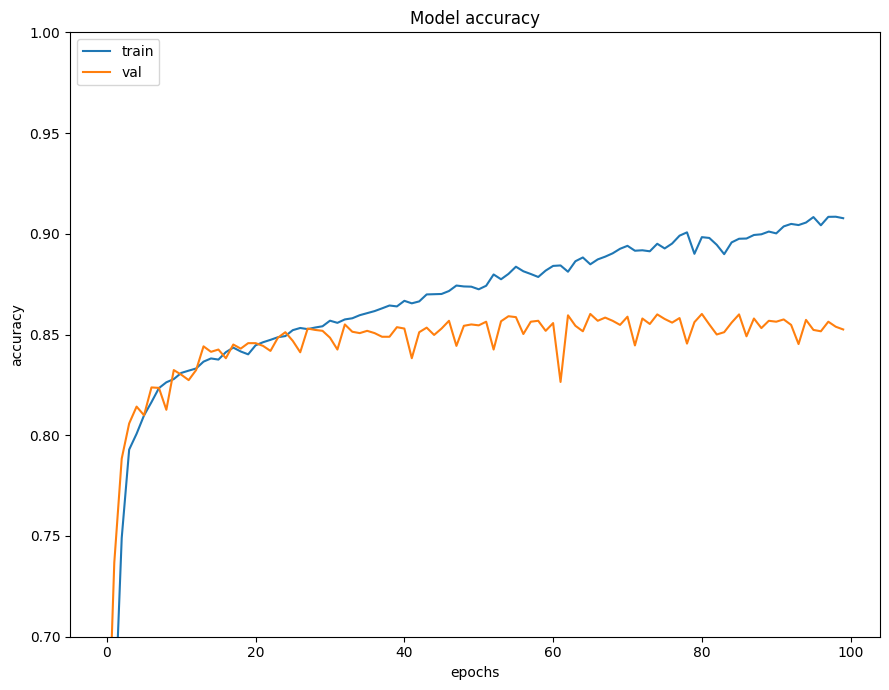

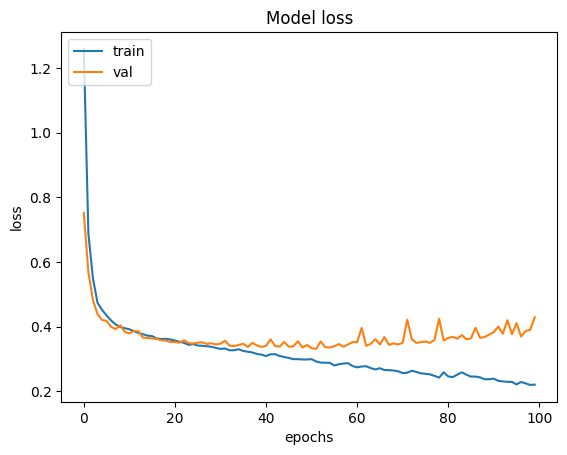

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[9,7])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.ylim((0.7,1))
plt.xlabel('epochs')
plt.legend(['train','val'], loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','val'], loc='upper left')
plt.show()

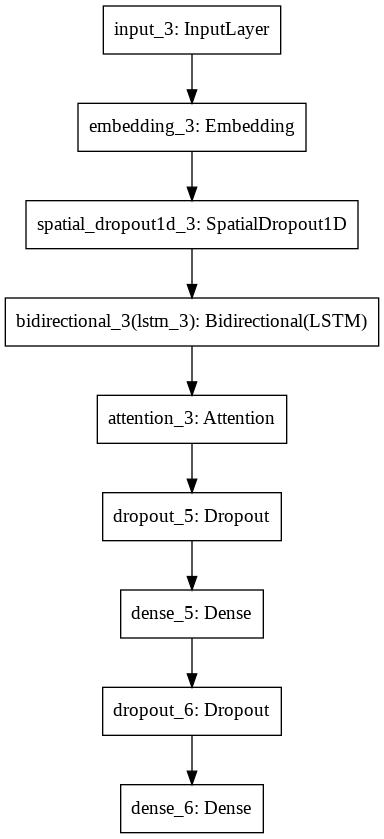

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')